In [1]:
%pip install -q -r ../../requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
import os
print(load_dotenv('../../.env'))
print(os.environ['LANGSMITH_PROJECT'])

True
agentic-ops


## VectorStore Setup
- Dockerfile
- Docker compose file

## docker compose --profile qdrant up -d

In [3]:
import os
import json
from typing import Annotated, TypedDict
from dotenv import load_dotenv
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain.document_loaders import HuggingFaceDatasetLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams

In [4]:
QDRANT_URL = "http://localhost:6333"

# Ingest Documents

In [5]:
def preprocess_dataset(docs_list):
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=700,
        chunk_overlap=50,
        disallowed_special=()
    )
    doc_splits = text_splitter.split_documents(docs_list)
    return doc_splits

In [6]:
# https://huggingface.co/datasets/m-ric/transformers_documentation_en
transformers_doc = HuggingFaceDatasetLoader("m-ric/transformers_documentation_en","text")
docs = preprocess_dataset(transformers_doc.load()[:50])
docs[0]

/Users/kartik/Documents/auto360/agents_course/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Document(metadata={'filename': 'perf_train_cpu_many.md'}, page_content='"\\n\\n# Efficient Training on Multiple CPUs\\n\\nWhen training on a single CPU is too slow, we can use multiple CPUs. This guide focuses on PyTorch-based DDP enabling distributed CPU training efficiently.\\n\\n## Intel\\u00ae oneCCL Bindings for PyTorch\\n\\n[Intel\\u00ae oneCCL](https://github.com/oneapi-src/oneCCL) (collective communications library) is a library for efficient distributed deep learning training implementing such collectives like allreduce, allgather, alltoall. For more information on oneCCL, please refer to the [oneCCL documentation](https://spec.oneapi.com/versions/latest/elements/oneCCL/source/index.html) and [oneCCL specification](https://spec.oneapi.com/versions/latest/elements/oneCCL/source/index.html).\\n\\nModule `oneccl_bindings_for_pytorch` (`torch_ccl` before version 1.12)  implements PyTorch C10D ProcessGroup API and can be dynamically loaded as external ProcessGroup and only works on

In [7]:
# set optimization 
vectorstore = QdrantVectorStore.from_documents(
    docs,
    OpenAIEmbeddings(model="text-embedding-3-small"),
    url=QDRANT_URL,
    collection_name="documentations",
)

## Agent Creation

In [8]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState

retriever = vectorstore.as_retriever()
tool = create_retriever_tool(
    retriever,
    "retriever_hugging_face_documentation",
    "Search and return information about hugging face documentation, it includes the guide and Python code."
)
print(tool)

sys_msg = SystemMessage(content="You are a helpful assistant that helps users with thier queries")
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools=[tool], parallel_tool_calls=False)

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

name='retriever_hugging_face_documentation' description='Search and return information about hugging face documentation, it includes the guide and Python code.' args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'> func=functools.partial(<function _get_relevant_documents at 0x107e57100>, retriever=VectorStoreRetriever(tags=['QdrantVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_qdrant.qdrant.QdrantVectorStore object at 0x12593ce60>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content') coroutine=functools.partial(<function _aget_relevant_documents at 0x126d67ec0>, retriever=VectorStoreRetriever(tags=['QdrantVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_qdrant.qdrant.QdrantVectorStore object at 0x12593ce60>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={

## Graph

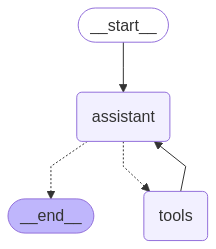

In [9]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([tool]))


builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()


display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
messages = [HumanMessage(content="what do you know about efficient Training on Multiple CPUs using Intel chips in huggingface ?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what do you know about efficient Training on Multiple CPUs using Intel chips in huggingface ?
================================== Ai Message ==================================
Tool Calls:
  retriever_hugging_face_documentation (call_yGYOpHhrAC6OHb3t4Y73XS2v)
 Call ID: call_yGYOpHhrAC6OHb3t4Y73XS2v
  Args:
    query: efficient Training on Multiple CPUs using Intel chips
================================= Tool Message =================================
Name: retriever_hugging_face_documentation

$torch_ccl_path/env/setvars.sh\n\n#### IPEX installation:\n\nIPEX provides performance optimizations for CPU training with both Float32 and BFloat16, you could refer [single CPU section](./perf_train_cpu).\n\nThe following \"Usage in Trainer\" takes mpirun in Intel\u00ae MPI library as an example.\n\n## Usage in Trainer\n\nTo enable multi CPU distributed training in the Trainer with the ccl backend, users should add **